In [63]:
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as plt

In [64]:
data = "../Data/processed/merged_data.csv"
df = pd.read_csv(data, parse_dates=["date"])
df.set_index("date", inplace=True)




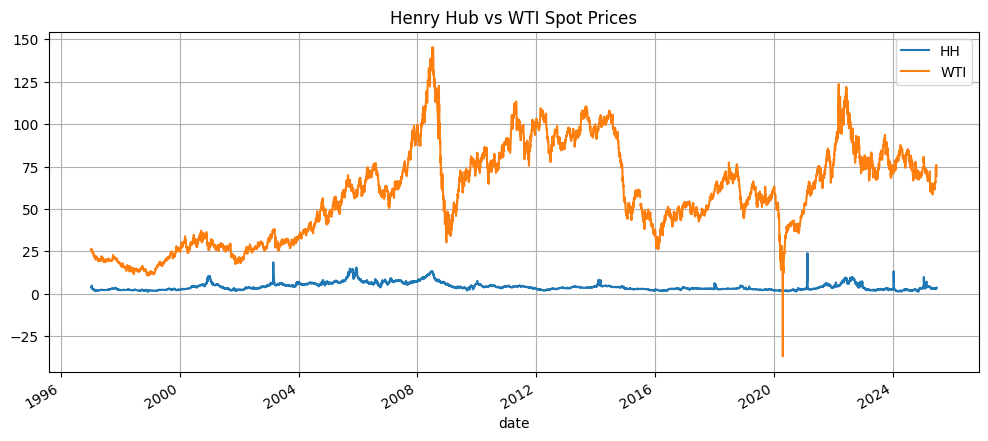

In [65]:
df.plot(y=["HH", "WTI"], figsize=(12, 5), title="Henry Hub vs WTI Spot Prices")
plt.grid(True)
plt.show()

#We can see that WTI has a generally upward trend, however has sharp volatility spikes i.e. in 2008 and in 2020. 
#Henry hub is hard to see from this, so we will plot it separately.


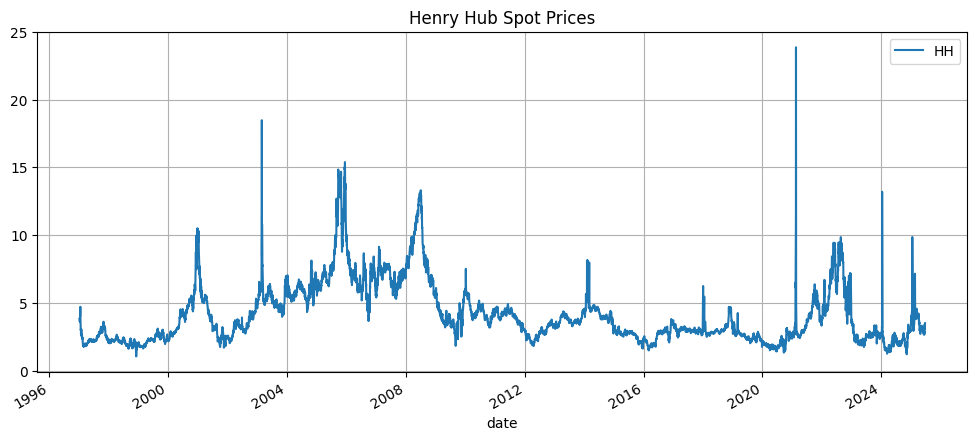

In [66]:
df.plot(y="HH", figsize=(12,5), title="Henry Hub Spot Prices")
plt.grid(True)
plt.show()

#Henry hub seems to have little trend, but has a lot of spikes.

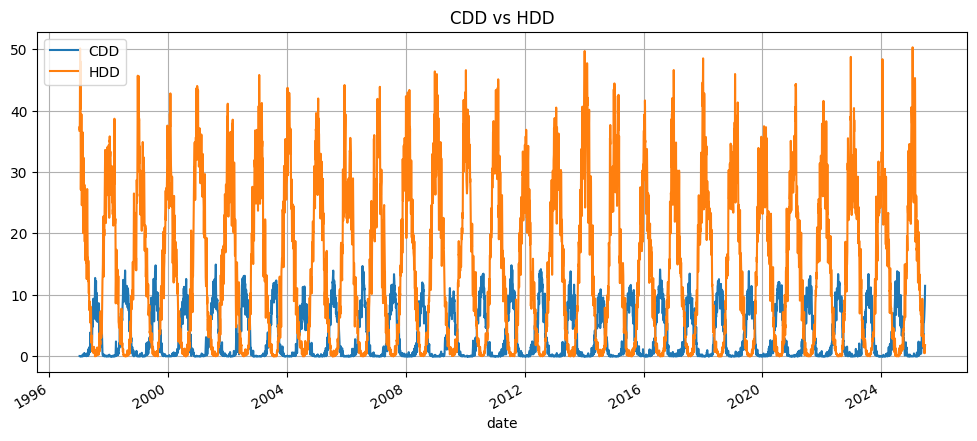

In [67]:

df.plot(y=["CDD", "HDD"], figsize=(12, 5), title="CDD vs HDD")
plt.grid(True)
plt.show()

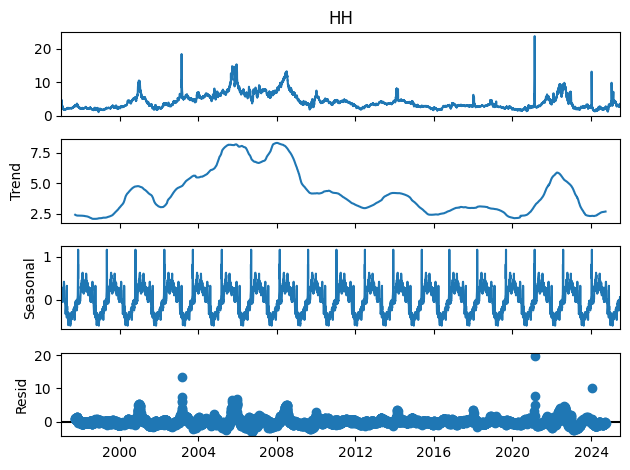

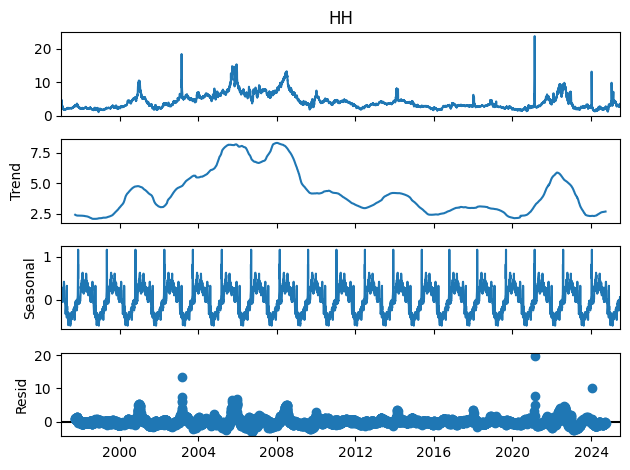

In [68]:
from statsmodels.tsa.seasonal import seasonal_decompose
res = seasonal_decompose(df['HH'], model='additive', period=365)
res.plot()

#trend shows no clear trend, but has a lot of strong spikes
#Seasonal shows a clear seasonal pattern, with peaks in Winter (heating) and July-August (cooling)

[Text(0.5, 1.0, '90-day rolling correlation with CDD and HDD'),
 Text(0, 0.5, 'Correlation')]

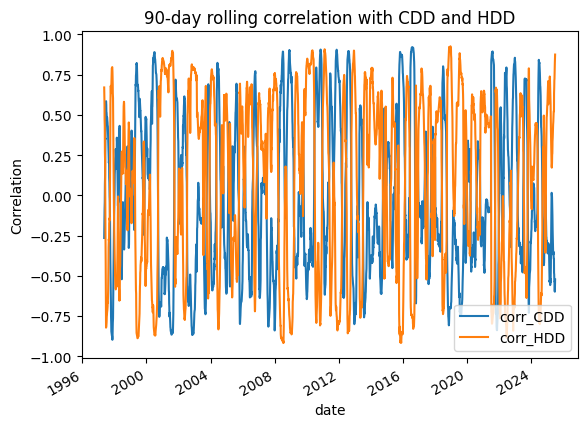

In [69]:
df['corr_CDD'] = df['HH'].rolling(90).corr(df['CDD'])
df['corr_HDD'] = df['HH'].rolling(90).corr(df['HDD'])
df[['corr_CDD','corr_HDD']].plot().set(title='90-day rolling correlation with CDD and HDD', ylabel='Correlation')

#Honestly just quite confused - correlation jumps around a lot
#Seems like it jumps and flips every few months from being strongly pos corr to strongly neg corr

Text(0, 0.5, 'CCF')

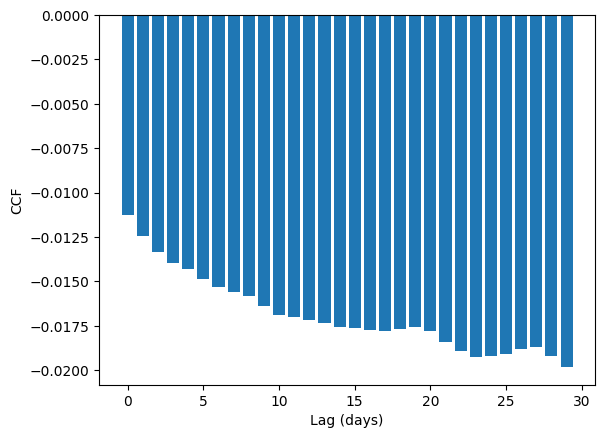

In [70]:
from statsmodels.tsa.stattools import ccf
xs = ccf(df['CDD'], df['HH'], adjusted=False)[:30]
plt.bar(range(len(xs)), xs); plt.xlabel("Lag (days)"); plt.ylabel("CCF")

#just shows corr is near 0 and slightly negative for the first 30 lags, which is not very useful

Text(0.5, 1.0, 'PACF of Henry Hub Spot Prices')

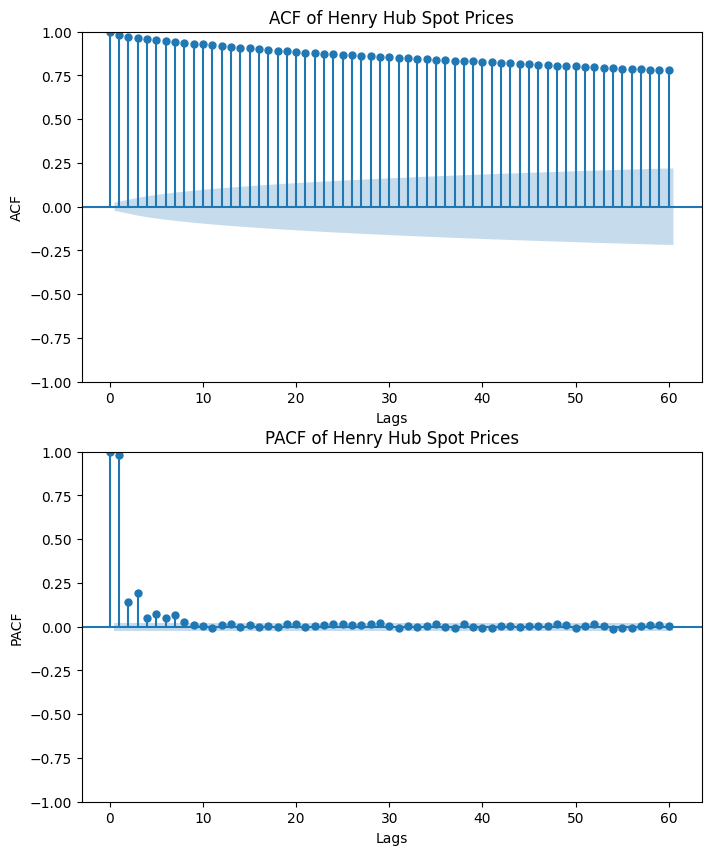

In [71]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2,1, figsize=(8,10))

plot_acf(df['HH'].dropna(), lags=60, ax=ax[0])
ax[0].set_xlabel('Lags')
ax[0].set_ylabel('ACF')
ax[0].set_title('ACF of Henry Hub Spot Prices')

plot_pacf(df['HH'].dropna(), lags=60, ax=ax[1])
ax[1].set_xlabel('Lags')
ax[1].set_ylabel('PACF')
ax[1].set_title('PACF of Henry Hub Spot Prices')    



#ACF and PACF plots show that there is a significant correlation at lag 1, with small corr at lag 2,3 and 4 - essentially saying that the majority of the correlation can be determined by lag 1 - which seems possibly stochastic?
#turns out AR(1) is a first order markov process so therefore this should work well for forecasting.

In [72]:
from statsmodels.tsa.stattools import adfuller
print(adfuller(df['HH']))

#very strong evidence that HH price is stationary, so we can fir AR(1) or ARIMAX

(np.float64(-4.3339413920361), np.float64(0.00038778726900056575), 7, 7142, {'1%': np.float64(-3.4312659411760427), '5%': np.float64(-2.8619447736790975), '10%': np.float64(-2.5669854569178376)}, np.float64(7072.045032973834))


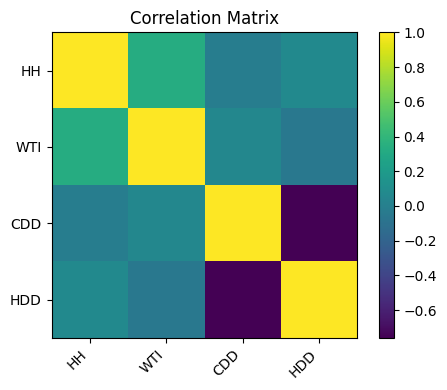

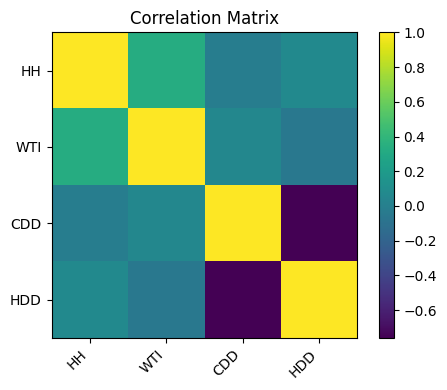

In [73]:
# Use the existing df variable, which already contains the merged data

# 1) Compute the correlation matrix
corr = df[["HH","WTI","CDD","HDD"]].corr()

# 3) Plot it
fig, ax = plt.subplots(figsize=(5,4))
im = ax.imshow(corr, aspect="equal")
ax.set_xticks(range(len(corr)))
ax.set_yticks(range(len(corr)))
ax.set_xticklabels(corr.columns, rotation=45, ha="right")
ax.set_yticklabels(corr.columns)
fig.colorbar(im, ax=ax)
ax.set_title("Correlation Matrix")
plt.tight_layout()
plt.show()
# 2) Plot it
fig, ax = plt.subplots(figsize=(5,4))
im = ax.imshow(corr, aspect="equal")
ax.set_xticks(range(len(corr)))
ax.set_yticks(range(len(corr)))
ax.set_xticklabels(corr.columns, rotation=45, ha="right")
ax.set_yticklabels(corr.columns)
fig.colorbar(im, ax=ax)
ax.set_title("Correlation Matrix")
plt.tight_layout()
plt.show()


In [74]:

# 1) Create some candidate weather features
df["CDD_7d_avg"] = df["CDD"].rolling(7, min_periods=1).mean()
df["HDD_7d_avg"] = df["HDD"].rolling(7, min_periods=1).mean()

# 2) Shift them by a variety of lags (1 to 14 days)
results = []
for lag in range(1, 15):
    cdd_col = f"CDD_7d_avg_lag{lag}"
    hdd_col = f"HDD_7d_avg_lag{lag}"
    df[cdd_col] = df["CDD_7d_avg"].shift(lag)
    df[hdd_col] = df["HDD_7d_avg"].shift(lag)
    # compute correlation with HH_spot on the aligned window
    corr_cdd = df[cdd_col].corr(df["HH"])
    corr_hdd = df[hdd_col].corr(df["HH"])
    results.append((lag, corr_cdd, corr_hdd))

# put into DataFrame
ccf = pd.DataFrame(results, columns=["lag","corr_CDD","corr_HDD"])
print(ccf)


    lag  corr_CDD  corr_HDD
0     1 -0.010902  0.063554
1     2 -0.010893  0.061182
2     3 -0.010913  0.059008
3     4 -0.010944  0.056904
4     5 -0.011041  0.054866
5     6 -0.011148  0.052847
6     7 -0.011205  0.050705
7     8 -0.011156  0.048489
8     9 -0.011099  0.046368
9    10 -0.011081  0.044451
10   11 -0.011102  0.042628
11   12 -0.011120  0.040784
12   13 -0.011129  0.039009
13   14 -0.011153  0.037487


In [75]:
# 2) generate rolling summaries of CDD & HDD
windows = [7, 14, 30, 90]
for w in windows:
    df[f"CDD_roll_{w}d_mean"] = df["CDD"].rolling(w, min_periods=1).mean()
    df[f"HDD_roll_{w}d_mean"] = df["HDD"].rolling(w, min_periods=1).mean()
    df[f"CDD_roll_{w}d_sum"]  = df["CDD"].rolling(w, min_periods=1).sum()
    df[f"HDD_roll_{w}d_sum"]  = df["HDD"].rolling(w, min_periods=1).sum()

# 3) shift each of those by 1–14 days to capture delayed effects
max_lag = 14
feature_cols = []
for w in windows:
    for stat in ("mean","sum"):
        base_cdd = f"CDD_roll_{w}d_{stat}"
        base_hdd = f"HDD_roll_{w}d_{stat}"
        for lag in range(1, max_lag+1):
            cdd_lag = f"{base_cdd}_lag{lag}"
            hdd_lag = f"{base_hdd}_lag{lag}"
            df[cdd_lag] = df[base_cdd].shift(lag)
            df[hdd_lag] = df[base_hdd].shift(lag)
            feature_cols += [cdd_lag, hdd_lag]

# 4) optional: extreme‐event flags
#    heatwave if 3-day sum in top 5% historically:
threshold = df["CDD"].rolling(3, min_periods=1).sum().quantile(0.95)
df["flag_heatwave_3d"] = (
    df["CDD"].rolling(3, min_periods=1).sum() > threshold
).astype(int)
feature_cols.append("flag_heatwave_3d")

# 5) examine which weather features move the needle most
#    compute their Pearson r with HH_spot
corrs = (
    df[feature_cols + ["HH"]]
     .corr()["HH"]
     .loc[feature_cols]
     .abs()
     .sort_values(ascending=False)
)
print("Top 10 weather features by |corr| with HH_spot:\n", corrs.head(10))

# 6) write out the engineered features
out = df[feature_cols + ["HH","WTI"]].dropna()





/var/folders/cr/5nwsh8711fs8v6254rwrv4300000gn/T/ipykernel_40048/2474306186.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[hdd_lag] = df[base_hdd].shift(lag)
/var/folders/cr/5nwsh8711fs8v6254rwrv4300000gn/T/ipykernel_40048/2474306186.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[cdd_lag] = df[base_cdd].shift(lag)
/var/folders/cr/5nwsh8711fs8v6254rwrv4300000gn/T/ipykernel_40048/2474306186.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

Top 10 weather features by |corr| with HH_spot:
 HDD_roll_7d_sum_lag1      0.063777
HDD_roll_7d_mean_lag1     0.063554
HDD_roll_7d_sum_lag2      0.061349
HDD_roll_7d_mean_lag2     0.061182
HDD_roll_7d_sum_lag3      0.059084
HDD_roll_7d_mean_lag3     0.059008
HDD_roll_14d_sum_lag1     0.057223
HDD_roll_7d_sum_lag4      0.056963
HDD_roll_7d_mean_lag4     0.056904
HDD_roll_14d_mean_lag1    0.056699
Name: HH, dtype: float64


In [76]:

# — 1) daily climatology (mean over all years) and anomaly —
# dayofyear 1–366
df["doy"] = df.index.dayofyear
# compute normal for each calendar day
clim = df.groupby("doy")[["CDD","HDD"]].transform("mean")
df["CDD_anom"] = df["CDD"] - clim["CDD"]
df["HDD_anom"] = df["HDD"] - clim["HDD"]

# — 2) exponentially-weighted moving average (EWMA) —
df["CDD_ewma21"] = df["CDD"].ewm(span=21, adjust=False).mean()
df["HDD_ewma21"] = df["HDD"].ewm(span=21, adjust=False).mean()

# — 3) a longer rolling sum (30 days) —
df["CDD_roll30_sum"] = df["CDD"].rolling(30, min_periods=1).sum()
df["HDD_roll30_sum"] = df["HDD"].rolling(30, min_periods=1).sum()

# — collect the new feature columns —
weather_features = [
    "CDD_anom","HDD_anom",
    "CDD_ewma21","HDD_ewma21",
    "CDD_roll30_sum","HDD_roll30_sum",
]

# — 4) check their absolute Pearson correlation with HH_spot —
corrs = df[weather_features + ["HH"]].corr()["HH"].loc[weather_features]
print("Anomaly/EWMA/30d-sum corrs:\n", corrs.abs().sort_values(ascending=False))

# — 5) if any move the needle (e.g. |r|>0.1), drop them into your XGB feature set —
out = df[weather_features + ["HH","WTI"]].dropna()






Anomaly/EWMA/30d-sum corrs:
 HDD_anom          0.165747
HDD_ewma21        0.055125
HDD_roll30_sum    0.047459
CDD_anom          0.016746
CDD_roll30_sum    0.011464
CDD_ewma21        0.011248
Name: HH, dtype: float64


/var/folders/cr/5nwsh8711fs8v6254rwrv4300000gn/T/ipykernel_40048/1291843772.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["doy"] = df.index.dayofyear
/var/folders/cr/5nwsh8711fs8v6254rwrv4300000gn/T/ipykernel_40048/1291843772.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["CDD_anom"] = df["CDD"] - clim["CDD"]
/var/folders/cr/5nwsh8711fs8v6254rwrv4300000gn/T/ipykernel_40048/1291843772.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which 